In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import random
import pickle as pkl
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()

In [2]:
class Linear(layers.Layer):
    '''
    Class for initializing a layer in Neural Network
    '''
    def __init__(self, units=32):
        '''
        constructor
        :param units: number of nodes in the layer
        '''
        super(Linear, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        '''
        Initialize weight and bias values of the layer
        :param w: weights
        :param b: bias
        '''
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
        
    def call(self, inputs):
        '''
        layer output
        '''
        return tf.matmul(inputs, self.w) + self.b

In [3]:
class NTBlock(layers.Layer):
    '''
    Neurotranmitter Block
    '''
    def __init__(self):
        super(NTBlock, self).__init__()
        self.layers = []
        self.layers.append(Linear(256))
        self.layers.append(Linear(128))
        self.layers.append(Linear(256))
        self.layers.append(Linear(784))
#         self.layers.append(Linear(1))
        
    def call(self, inputs, calc_loss=False):
        # store layers in decoder to decoder_layers
        decoder_layers = []
        x = self.layers[0](inputs)
        # Z1 = first layer with 312 neurons
        Z1 = tf.nn.sigmoid(x)
        Z2 = self.layers[1](Z1)
        # Z2 = second layer with 128 neurons
        Z2 = tf.nn.sigmoid(Z2)
        # collect the hidden layer in decoder_layers
        decoder_layers.insert(0, Z2)
        Z1_bar = self.layers[2](Z2)
        # Z1_bar = back to first layer with 312 neurons
        Z1_bar = tf.nn.sigmoid(Z1_bar)
        decoder_layers.insert(0, Z1_bar)
        x_bar = self.layers[3](Z1_bar)
        # x_bar = back to input layer with 784 neurons
        x_bar = tf.nn.sigmoid(x_bar)
        
        if calc_loss:
            # calculate layer wise loss in autoencoder
            nt_loss = custom_bce(Z1_bar, Z1) * Z1.shape[0] + custom_bce(x_bar, inputs) * inputs.shape[0]
            return x_bar, nt_loss
        else:
            return x_bar, decoder_layers

In [4]:
class MLPBlock(layers.Layer):
    '''
    Neural Network Block
    '''
    def __init__(self):
        '''
        Architecture of the neural network i.e.
        number of layers and nodes in each layer
        '''
        super(MLPBlock, self).__init__()
        self.layers = []
        self.layers.append(Linear(256))
        self.layers.append(Linear(128))
        self.layers.append(Linear(1))
        
    def call(self, inputs, d_layers=None, mu=0.1):
        '''
        Forward pass of the neural network
        '''
        if d_layers:
            x = self.layers[0](inputs)
            x = tf.nn.relu(x) * mu * d_layers[0]
            x = self.layers[1](x)
            x = tf.nn.relu(x) * mu * d_layers[1]
            x = self.layers[2](x)
            x = tf.math.sigmoid(x)
        else:
            x = self.layers[0](inputs)
            x = tf.nn.relu(x)
            x = self.layers[1](x)
            x = tf.nn.relu(x)
            x = self.layers[2](x)
            x = tf.math.sigmoid(x)
        return x

In [62]:
class DPN(layers.Layer):
    def __init__(self, tau):
        super(DPN, self).__init__()
        self.tau = tau
        self.layers = []
        self.layers.append(Linear(312))
        self.layers.append(Linear(128))
        self.layers.append(Linear(312))
        self.layers.append(Linear(784))
        self.layers.append(Linear(312))
        self.layers.append(Linear(128))
        self.layers.append(Linear(1))
        
    def call(self, inputs):
        Z0 = self.layers[0](inputs)
        Z1 = tf.nn.sigmoid(Z0)
        Z2 = self.layers[1](Z1)
        Z2 = tf.nn.sigmoid(Z2)
        Z1_hat = self.layers[2](Z2)
        Z1_hat = tf.nn.sigmoid(Z1_hat)
        Z0_hat = self.layers[3](Z1)
        Z0_hat = tf.nn.sigmoid(Z0_hat)
        
        l0 = self.layers[4](inputs)
        l1 = tf.nn.relu(l0) * (self.tau * Z1 + (1-self.tau))
        l2 = self.layers[5](l1)
        l2 = tf.nn.relu(l2) * (self.tau * Z2 + (1-self.tau)) 
        y = self.layers[6](l2)
        y = tf.nn.sigmoid(y)
        
        # Calculating layer wise KL-Divergence using 'sum' reduction type.
        mse = tf.keras.losses.MeanSquaredError()
        loss = mse(inputs, Z0_hat) + mse(Z1, Z1_hat)
#         loss = custom_bce(Z0_hat, inputs) + custom_bce(Z1_hat, Z1)
#         loss = custom_KLD(Z0_hat, inputs) + custom_KLD(Z1_hat, Z1)
#         kld = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
#         loss = kld(inputs, Z0_hat) + kld(Z1, Z1_hat)
        
        return y, loss

In [21]:
def custom_bce(p, y, offset=1e-7): #1e-10
    p_ = tf.clip_by_value(p, offset, 1 - offset)
    vec_bce = -tf.reduce_sum(y * tf.math.log(p_) + (1.0 - y) * tf.math.log(1.0 - p_), axis=1)
    return tf.reduce_sum(vec_bce)/y.shape[0]

def custom_KLD(q, p, offset=1e-7): # q is model predictive/approximating distribution, p is target distribution
    q_ = tf.clip_by_value(q, offset, 1 - offset)
    p_ = tf.clip_by_value(p, offset, 1 - offset)
    vec_bce = tf.reduce_sum(p_ * (tf.math.log(p_) - tf.math.log(q_)))
    return tf.reduce_sum(vec_bce)/p.shape[0]

In [7]:
def relabel(labels):
    '''
    task wise relabel the dataset as combination of 0's and 1's
    '''
    new_labels = np.empty((0, labels.shape[0]))
    for task in range(10):
        positives = np.where(labels[:,task] == 1)[0]
        task_labels = np.zeros(labels.shape[0])
        task_labels[positives] = 1
        new_labels = np.vstack((new_labels, task_labels))
#     new_labels = tf.convert_to_tensor(new_labels, dtype=tf.float32)
    return new_labels

In [8]:
def batch_loader(labels, batch_size, class_bal=False):
    '''
    load random batches of data
    '''
    # if class balance is not required in every batch
    if not class_bal:
        indices = np.arange(labels.shape[0])
        for _ in range(5): np.random.shuffle(indices)
        batches = np.asarray(list(divide_chunks(indices, batch_size)))
        return batches
    
    # if class balance is needed in every batch
    else:
        positives = np.where(labels==1)[0]
        negatives = np.arange(labels.shape[0])
        negatives = np.delete(negatives, positives)
        np.random.shuffle(negatives)
        np.random.shuffle(positives)
        task_batch = []
        # create batches by iteratively scraping out chunks out of positives array
        while positives.shape[0] > 0:
            if len(positives) >= batch_size/2:
                # create a batch such that positive (batch_size/2) is added with sampled negatives (batch_size/2)
                temp = np.concatenate((positives[:batch_size//2], np.random.choice(negatives, batch_size//2)))
                positives = positives[batch_size//2: ]
            else:
                # for the last batch where no. of positive could be < batch_size
                temp = np.concatenate((positives, np.random.choice(negatives, len(positives))))
                positives = np.array([])
            np.random.shuffle(temp)
            task_batch.append(temp)
        return np.asarray(task_batch)

In [9]:
trainX = pd.read_csv('mnist_clean/trainX.tsv', sep="\t", header=None, index_col=False).to_numpy()
trainY = pd.read_csv('mnist_clean/trainY.tsv', sep="\t", header=None, index_col=False).to_numpy()
testX = pd.read_csv('mnist_clean/testX.tsv', sep="\t", header=None, index_col=False).to_numpy()
testY = pd.read_csv('mnist_clean/testY.tsv', sep="\t", header=None, index_col=False).to_numpy()
validX = pd.read_csv('mnist_clean/validX.tsv', sep="\t", header=None, index_col=False).to_numpy()
validY = pd.read_csv('mnist_clean/validY.tsv', sep="\t", header=None, index_col=False).to_numpy()

trainY = relabel(trainY)
testY = relabel(testY)
validY = relabel(validY)

In [24]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
bce = tf.keras.losses.BinaryCrossentropy()
net = MLPBlock()
autoencoder = NTBlock()
dpn = DPN(tau=0)
n_tasks = 10
n_epochs = 5
tau = 0

# declare array for collecting train loss
# train_losses[t] = [n_epochs x n_tasks]
train_losses = {}
test_losses = {}
valid_losses = {}
train_accuracy = {}
valid_accuracy = {}
test_accuracy = {}
train_autoencoder_loss = {}
valid_autoencoder_loss = {}
test_autoencoder_loss = {}
for t in range(n_tasks):
    train_losses[t] = []
    valid_losses[t] = []
    train_accuracy[t] = []
    valid_accuracy[t] = []
    test_losses[t] = []
    test_accuracy[t] = []
    train_autoencoder_loss[t] = []
    valid_autoencoder_loss[t] = []

# calculate b_bar loss
for task in range(n_tasks):
    train_loss = 0
    train_acc = 0
    loss_at = 0
    size = 0
    batches = batch_loader(trainY[task], 50, class_bal=True)
    for batch in batches:
        output, autoencoder_loss = dpn(trainX[batch])
        size += batch.shape[0]
        temp = trainY[task, batch].reshape(output.shape)
        temp = tf.cast(temp, dtype=tf.float32)
        train_loss += (custom_bce(output, temp) + tar*autoencoder_loss) * batch.shape[0]
        loss_at += autoencoder_loss * batch.shape[0]
        output = output.numpy().reshape(-1)
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        train_acc += np.sum(output == trainY[task, batch])
    train_losses[task].append(train_loss/size)
    train_accuracy[task].append(train_acc/size)
    train_autoencoder_loss[task].append(loss_at/size)
    
    valid_loss = 0
    valid_acc = 0
    loss_at = 0
    size = 0
    batches = batch_loader(validY[task], 50, class_bal=True)
    for batch in batches:
        output, autoencoder_loss = dpn(validX[batch])
        size += batch.shape[0]
        temp = validY[task, batch].reshape(output.shape)
        temp = tf.cast(temp, dtype=tf.float32)
        valid_loss += (custom_bce(output, temp) + tau*autoencoder_loss) * batch.shape[0]
        loss_at += autoencoder_loss * batch.shape[0]
        output = output.numpy().reshape(-1)
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        valid_acc += np.sum(output == validY[task, batch])
    valid_losses[task].append(valid_loss/size)
    valid_accuracy[task].append(valid_acc/size)
    valid_autoencoder_loss[task].append(loss_at/size)

# train and calculate BWT, FWT
for task in range(n_tasks):
    for epoch in range(n_epochs):
        total_loss = 0
        batches = batch_loader(trainY[task], 50, class_bal=True)
        for batch in batches:
            with tf.GradientTape() as tape:
                output, autoencoder_loss = dpn(trainX[batch])
                batch_loss = custom_bce(output, trainY[task, batch]) + tau*autoencoder_loss
            grads = tape.gradient(batch_loss, dpn.trainable_weights)
            optimizer.apply_gradients(zip(grads, dpn.trainable_weights))

        for t in range(n_tasks):
            loss = 0
            train_acc = 0
            loss_at = 0
            size = 0
            batches = batch_loader(trainY[t], 50, class_bal=True)
            for batch in batches:
                output, autoencoder_loss = dpn(trainX[batch])
#                 reconstructed_x, autoencoder_loss = autoencoder(trainX[batch], calc_loss=True)
#                 print('task %s= output:' % (task, output))
                size += batch.shape[0]
                temp = tf.convert_to_tensor(trainY[t, batch].reshape(output.shape), dtype=tf.float32)
                loss += (custom_bce(output, temp) + tau*autoencoder_loss) * batch.shape[0]
                loss_at += autoencoder_loss * batch.shape[0]
                output = output.numpy().reshape(-1)
                output[output >= 0.5] = 1
                output[output < 0.5] = 0
                train_acc += np.sum(output == trainY[t, batch])
            train_losses[t].append(loss/size)
            train_accuracy[t].append(train_acc/size)
            train_autoencoder_loss[t].append(loss_at/size)
        
        for t in range(n_tasks):
            valid_loss = 0
            valid_acc = 0
            loss_at = 0
            size = 0            
            batches = batch_loader(validY[t], 50, class_bal=True)
            for batch in batches:
                output, autoencoder_loss = dpn(validX[batch])
                size += batch.shape[0]
                temp = tf.convert_to_tensor(validY[t, batch].reshape(output.shape), dtype=tf.float32)
                valid_loss += (custom_bce(output, temp) + tau*autoencoder_loss) * batch.shape[0]
                loss_at += autoencoder_loss * batch.shape[0]
                output = output.numpy().reshape(-1)
                output[output >= 0.5] = 1
                output[output < 0.5] = 0
                valid_acc += np.sum(output == validY[t, batch])
            valid_losses[t].append(valid_loss/size)
            valid_accuracy[t].append(valid_acc/size)
            valid_autoencoder_loss[t].append(loss_at/size)
    
        print('----- epoch %s completed -----' % (epoch))

    print('--------------------- Task %s completed ---------------------' % task)
    


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

----- epoch 0 co

In [ ]:
for t in range(n_tasks):
    test_loss = 0
    test_acc = 0
    loss_at = 0
    size = 0            
    batches = batch_loader(testY[t], 50, class_bal=True)
    for batch in batches:
        output, autoencoder_loss = dpn(testX[batch])
        size += batch.shape[0]
        temp = tf.convert_to_tensor(testY[t, batch].reshape(output.shape), dtype=tf.float32)
        test_loss += (custom_bce(output, temp) + autoencoder_loss) * batch.shape[0]
        loss_at += autoencoder_loss * batch.shape[0]
        output = output.numpy().reshape(-1)
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        test_acc += np.sum(output == testY[t, batch])
    test_losses[t].append(test_loss/size)
    test_accuracy[t].append(test_acc/size)
    test_autoencoder_loss[t].append(loss_at/size)

In [ ]:
data_dict = {'train_loss': train_losses,
             'valid_loss': valid_losses,
             'test_loss': test_losses,
             'train_acc': train_accuracy,
             'valid_acc': valid_accuracy,
             'test_acc': test_accuracy,
             'train_autoencoder_loss': train_autoencoder_loss,
             'valid_autoencoder_loss': valid_autoencoder_loss,
             'test_autoencoder_loss': test_autoencoder_loss}

pkl.dump(data_dict, open('dpn_data_dict.pkl', 'wb'))
print('Experiment completed')

In [6]:
data_dict = pkl.load(open('results/dpn_data_dict.pkl', 'rb'))
data_dict.keys()

dict_keys(['train_loss', 'valid_loss', 'test_loss', 'train_acc', 'valid_acc', 'test_acc', 'train_autoencoder_loss', 'valid_autoencoder_loss', 'test_autoencoder_loss'])

<IPython.core.display.Javascript object>


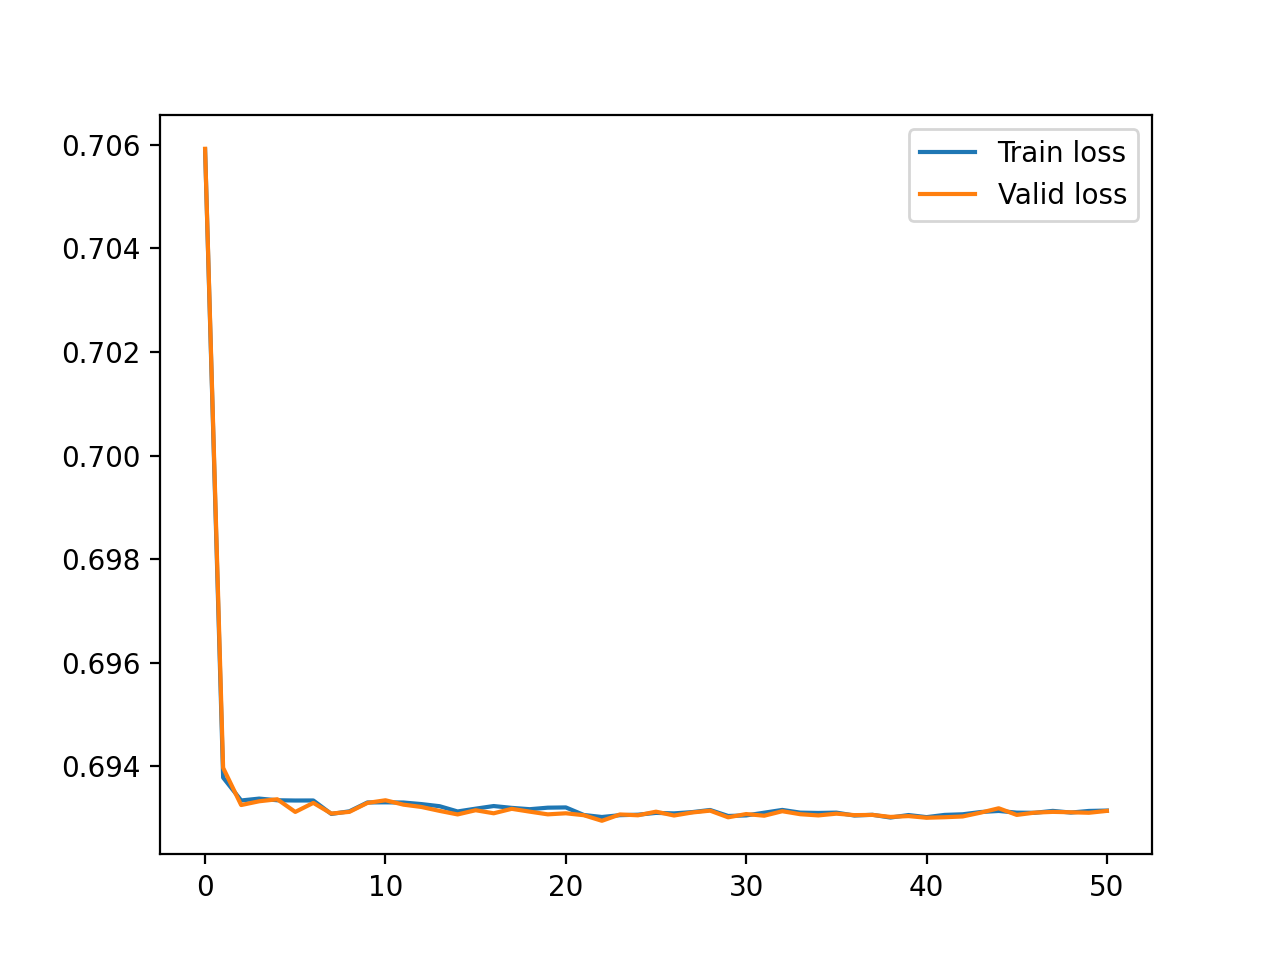

In [7]:
plt.plot(data_dict['train_loss'][0], label='Train loss')
plt.plot(data_dict['valid_loss'][0], label='Valid loss')
plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


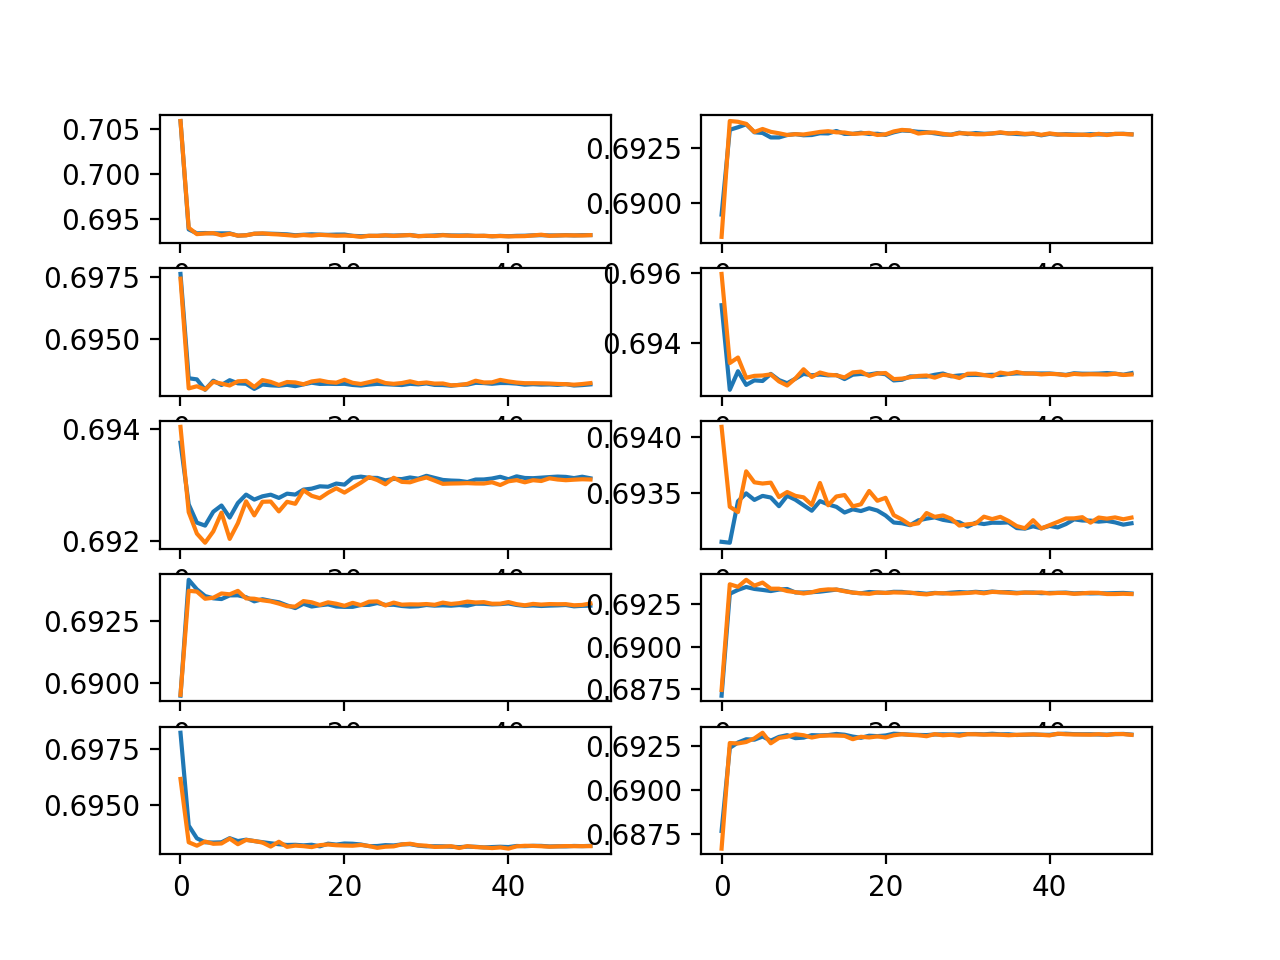

In [8]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=5, ncols=2)
count = 0
for r in range(5):
    for c in range(2):
        ax[r,c].plot(data_dict['train_loss'][count])
        ax[r,c].plot(data_dict['valid_loss'][count])
        count += 1
plt.show()

<IPython.core.display.Javascript object>


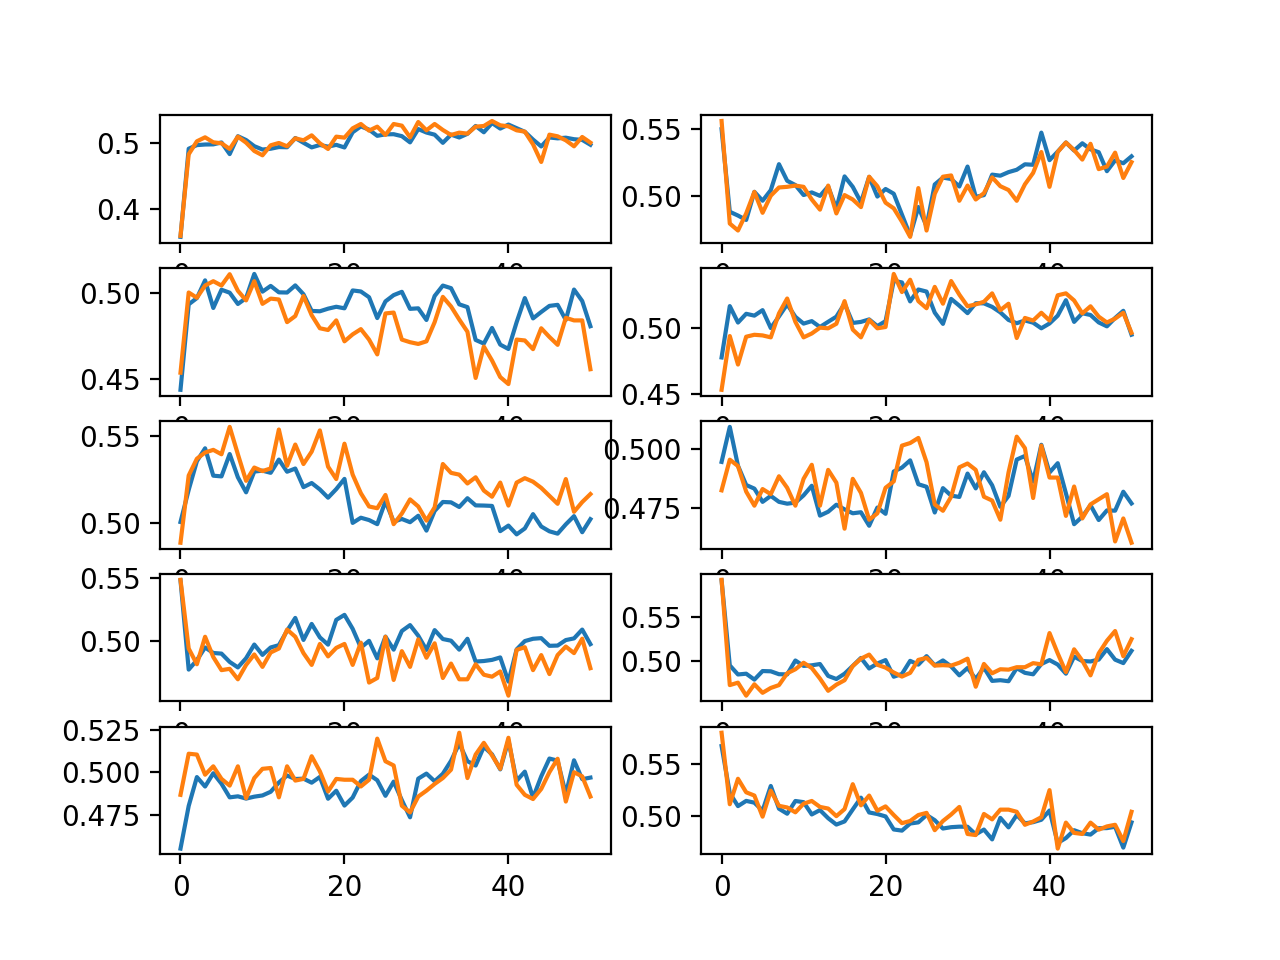

In [9]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=5, ncols=2)
count = 0
for r in range(5):
    for c in range(2):
        ax[r,c].plot(data_dict['train_acc'][count])
        ax[r,c].plot(data_dict['valid_acc'][count])
        count += 1
plt.show()

<IPython.core.display.Javascript object>


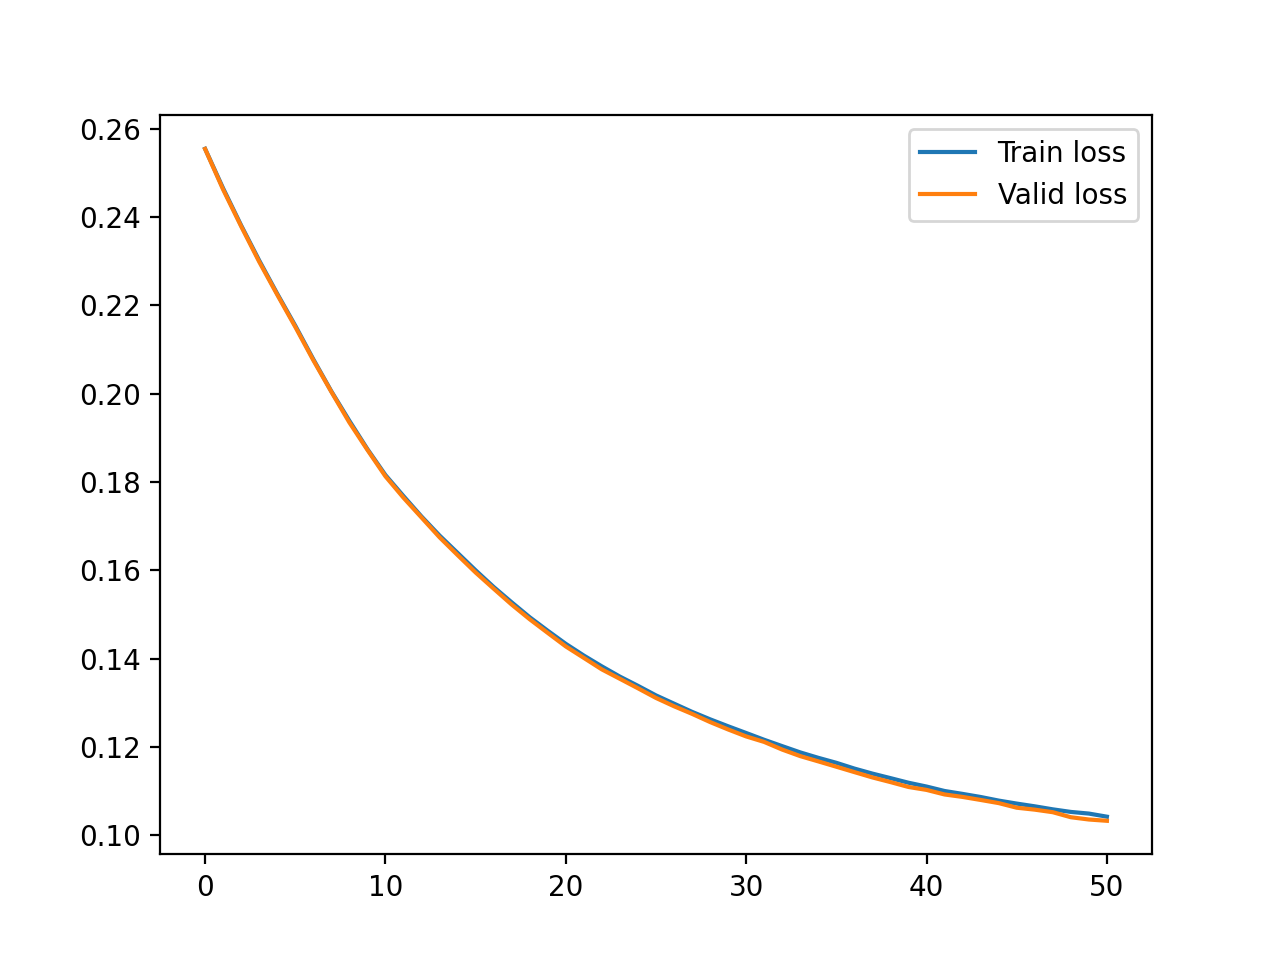

In [53]:
plt.plot(data_dict['train_autoencoder_loss'][0], label='Train loss')
plt.plot(data_dict['valid_autoencoder_loss'][0], label='Valid loss')
plt.legend(loc='upper right')
plt.show()